In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(rvest)
library(stringr)
library(DBI)
library(dbplyr)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

# Predicting the Win Rate of Tennis Players

# Introduction
### Background 

Tennis is a popular, competitive sport played around the world. In tennis, players gain points by hitting a tennis ball, across a net in the court, in such a way that their opponent is unable to hit it back without the ball bouncing twice. 
Tennis can be played in "singles" where there is only one person on each side of the net or "doubles" where there are teams of two. 
It can be played on a variety of surfaces such as grass, clay, or hard court (i.e. like a gym floor).

- Professional tennis players participate in large **tournaments** for ranks, prizes, and fame. 
- In a tournament, players advance to the next round by winning their **match** against an opponent. 
- To win a match, a player must win two (or three, depending on the tournament) **sets**. 
- A set is won by the player who wins six **games**.
- A game is won by the first player to reach four **points**

The association of tennis professionals, or ATP, organizes these tournaments and also collects data on the players and the matches that take place.

### Our Question

Based on the career statistics of a tennis player, what will be their win rate?

### Our Dataset

We are using the "Game results for Top 500 Players from 2017-2019" dataset for our analysis. Each row in this dataset represents a match between two players. Each row contains player stats (e.g. age, height, rank) and match stats (break points, serve points, double faults etc.). We use group_by and summarize per player for this dataset to calculate the average stats for their career. Then, we can determine the relationship between player stats and win rate.


# Preliminary Exploratory Data Analysis

In [3]:
## the dataset can be read from the URL link:
atp_data_frame <- read_csv("https://drive.google.com/uc?export=download&id=1fOQ8sy_qMkQiQEAO6uFdRX4tLI8EpSTn")
head(atp_data_frame)

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_double(),
  tourney_id = col_character(),
  tourney_name = col_character(),
  surface = col_character(),
  tourney_level = col_character(),
  winner_seed = col_character(),
  winner_entry = col_character(),
  winner_name = col_character(),
  winner_hand = col_character(),
  winner_ioc = col_character(),
  loser_seed = col_character(),
  loser_entry = col_character(),
  loser_name = col_character(),
  loser_hand = col_character(),
  loser_ioc = col_character(),
  score = col_character(),
  round = col_character()
)

See spec(...) for full column specifications.



X1,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,⋯,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2019-M020,Brisbane,Hard,32,A,20181231,300,105453,2,⋯,54,34,20,14,10,15,9,3590,16,1977
1,2019-M020,Brisbane,Hard,32,A,20181231,299,106421,4,⋯,52,36,7,10,10,13,16,1977,239,200
2,2019-M020,Brisbane,Hard,32,A,20181231,298,105453,2,⋯,27,15,6,8,1,5,9,3590,40,1050
3,2019-M020,Brisbane,Hard,32,A,20181231,297,104542,NA,⋯,60,38,9,11,4,6,239,200,31,1298
4,2019-M020,Brisbane,Hard,32,A,20181231,296,106421,4,⋯,56,46,19,15,2,4,16,1977,18,1855
5,2019-M020,Brisbane,Hard,32,A,20181231,295,104871,NA,⋯,54,40,18,15,6,9,40,1050,185,275


In [4]:

# calculate player wins and mean match stats for winning matches
player_wins <- atp_data_frame %>%
    group_by(player_id = winner_id) %>%
    summarize(w_height = mean(winner_ht, na.rm =TRUE),
              w_breakpoint_saved_pct = mean(w_bpSaved/w_bpFaced, na.rm =TRUE),
              w_second_serve_win_pct = mean(w_2ndWon / w_svpt,na.rm =TRUE),
              w_df_pct = mean(w_df / w_svpt,na.rm =TRUE),
              w_first_serve_pct = mean(w_1stWon / w_1stIn,na.rm =TRUE),
              n_wins = n(),
              mean_age_w  = mean(winner_age),
              mean_rank_points_w = mean(winner_rank_points)    
             ) %>%
    drop_na() %>%
    mutate(player_id = as.character(player_id))

# calculate player losses and mean match stats for losing matches
player_lose <- atp_data_frame %>%
    group_by(player_id = loser_id) %>%
    summarize(l_height = mean(loser_ht, na.rm =TRUE),
              l_breakpoint_saved_pct = mean(l_bpSaved/l_bpFaced, na.rm =TRUE),
              l_second_serve_win_pct = mean(l_2ndWon / l_svpt,na.rm =TRUE),
              l_df_pct = mean(l_df / l_svpt, na.rm =TRUE),
              l_first_serve_pct = mean(l_1stWon / l_1stIn,na.rm =TRUE),
              n_lose = n(),
              mean_age_l  = mean(loser_age),
              mean_rank_points_l = mean(loser_rank_points)    
             ) %>%
    drop_na() %>%
    mutate(player_id = as.character(player_id))

# join datasets for wins and losses using unique player ids
player_join <- left_join(player_wins, player_lose, by = NULL, copy = TRUE)

# calculate career stats for all player matches
player_career <- player_join %>%
    mutate(height = (w_height + l_height)/2,
          breakpoint_saved_pct = (w_breakpoint_saved_pct+l_breakpoint_saved_pct)/2,
          second_serve_win_pct = (w_second_serve_win_pct+l_second_serve_win_pct)/2,
          df_pct = (w_df_pct+l_df_pct)/2,
          first_serve_pct = (w_first_serve_pct+l_first_serve_pct)/2,
          win_rate = (n_wins/(n_lose+n_wins)*100),
          age = (mean_age_w + mean_age_l) /2,
          mean_rank_points = (mean_rank_points_w + mean_rank_points_l)/2) %>%
    select(player_id,height,breakpoint_saved_pct,second_serve_win_pct,df_pct,first_serve_pct,win_rate,age,mean_rank_points) %>%
    drop_na()

player_career

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

Joining, by = "player_id"



player_id,height,breakpoint_saved_pct,second_serve_win_pct,df_pct,first_serve_pct,win_rate,age,mean_rank_points
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100644,198,0.5592240,0.1700660,0.05146736,0.7351579,69.34673,21.15730,4281.6435
103333,208,0.7024075,0.1934502,0.05467902,0.8336761,41.02564,39.12084,962.8682
103819,185,0.6093525,0.2114465,0.02279807,0.7770562,84.17722,37.09069,6720.2910
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
106296,183,0.5769397,0.1768606,0.04200586,0.6743243,33.33333,25.12377,458.375
106298,185,0.6420310,0.2225114,0.04366584,0.7383816,58.08824,24.20236,1914.473
106401,193,0.6480872,0.1862049,0.04705221,0.7819567,62.71186,23.02092,1722.535


We have grouped each unique player's matches together and calculated the mean of several key stats, creating a sort of "career average" dataframe. Additionally, we have introduced a new stat, *win_rate*, which is found by dividing the number of times a player was in the winning column by the total amount of times that player appeared in the dataframe.

In [6]:
set.seed(1)
player_split <- initial_split(player_career, prop = 0.75, strata = win_rate)
player_train <- training(player_split)
player_test <- testing(player_split)

print("Creating recipe")
tennis_recipe <- recipe(win_rate ~ ., data = player_train) %>%
  step_rm(player_id) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

print("Creating spec")
tennis_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("regression")

print("Creating folds")
tennis_vfold <- vfold_cv(player_train, v = 5, strata = win_rate)

print("Creating workflow")
tennis_wkflw <- workflow() %>%
  add_recipe(tennis_recipe) %>%
  add_model(tennis_spec)

gridvals <- tibble(neighbors = seq(1,50))

print("Tuning grid")
tennis_results <- tennis_wkflw %>%
    tune_grid(resamples = tennis_vfold, grid = gridvals) %>%
    collect_metrics()

tennis_min <- tennis_results %>%
    filter(.metric == "rmse") %>%
    arrange(mean) %>%
    slice(1)

tennis_min

[1] "Creating recipe"
[1] "Creating spec"
[1] "Creating folds"


Warning message:
“The number of observations in each quantile is below the recommended threshold of 20. Stratification will be done with 3 breaks instead.”


[1] "Creating workflow"
[1] "Tuning grid"


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,rmse,standard,10.26389,5,0.7897034,Model02


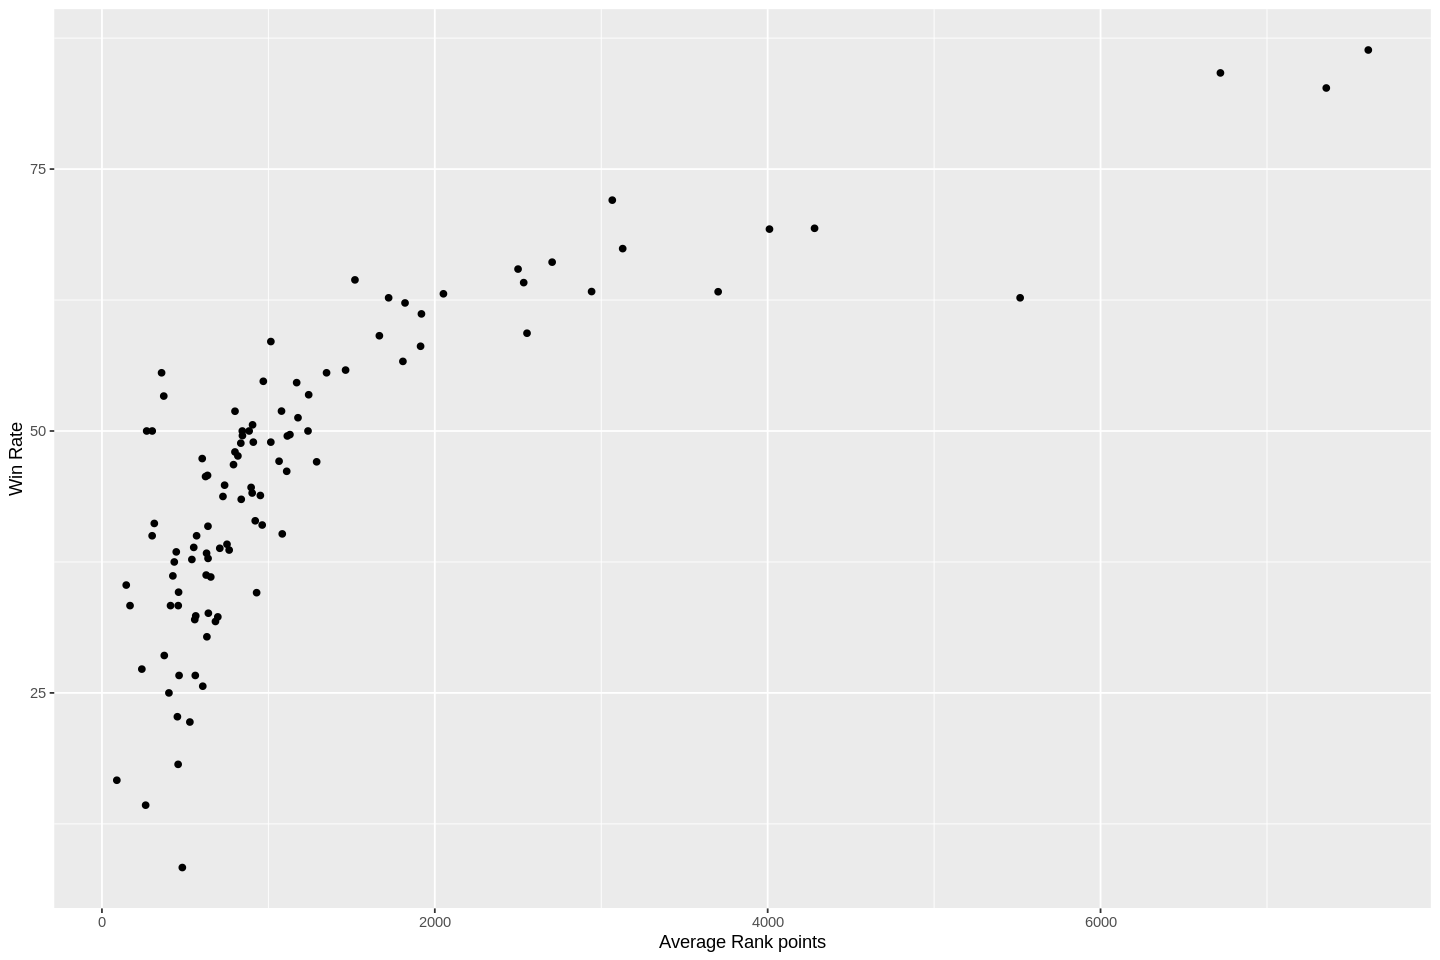

In [7]:
ggplot(player_career, aes(x=mean_rank_points,y=win_rate)) + 
    geom_point() +
    xlab("Average Rank points") +
    ylab("Win Rate")

We can see that the relationship between average career rank points and win rate is strongly positive, and non-linear. This sets up nicely for a KNN regression model.

# Methods

Each winner and loser of a match will have their stats mutated into three percentage predictors which will be used to Classify whether or not that player was the Winner or Loser of the match. The first predictor calculates successful saved breakpoints while the second and third predictors calculate serves and whether or not that Player won a point on their second serve or received a double fault.

We can apply these values by using scatterplot graphs to compare the Winner and Loser stats for each match and visualize a trend. For example, we can compare the amount of points won on the second serve versus the number of double faults and have each point colored on whether or not that player won or lost the match.

# Expected outcomes and significance

We expect that the estimated win rate will reflect the respective career stats of the player. For example, if they have impressive stats, such as a high breakpoint saved percentage and high rank points, then their win rate will be high. Conversely, if our player has poor stats, their win rate will reflect this and be lower. 

